# **2025 ML FALL HW1: PM2.5 Prediction (Regression)**

Author: MLTAs

Methods:
* Training with all data
* Optimizer: RMSProp (default)
* TODOs:
  - Complete the `valid()` function
  - Tune the hyperparameters in `train_config`
  - Implement 2nd-order polynomial regression model (without interaction terms) in `minibatch_2()`
  - Implement feature normalization in `normalize_train_data()`
  - Feature selection



# **Import Some Packages**

In [923]:
import numpy as np
import csv
import math
import pandas as pd
import os

# **Fix random seed**


This is for the reproduction of your result. **DO NOT modify this secton!**


In [924]:
seed = 9487
np.random.seed(seed)

# **Download training data**


In [925]:
# !gdown --id "1Hfzrcm69QwdFvdeF0uASoQlcVxKw_hHy" --output "train.csv"
# !gdown --id '155N6fzI7vAFzHAGdy6jkaWIksWH6Y1G2' --output "test.csv"

# Incase the links above die, you can use the following instead.
#!gdown --id '11abE854Eyv4BA7qt5k8r_80sJ3KuOQUN' --output "train.csv"
#!gdown --id '1uod-Z4ztluXnuHtgUbm39nMudUKqXHMl' --output "test.csv"

# If the data is still missing, you can manually download it from kaggle, and upload the files under /content

In [ ]:
def valid(x, y, y_mean, y_std):
  # TODO: Try to filter out extreme values.
  # Exclude data points with y over 2.5 standard deviations from the mean

  std_thresh = 0.6
  if y > y_mean + std_thresh * y_std or y < y_mean - std_thresh * y_std:
    return False

  return True


# Create your dataset
def parse2train(data, feats):

  x = []
  y = []

  # Use data #0~#7 to predict #8 => Total data length should be decresased by 8.
  total_length = data.shape[1] - 8

  for i in range(total_length):
    x_tmp = data[feats, i:i+8] # Use data #0~#7 to predict #8, data #1~#8 to predict #9, etc.
    y_tmp = data[-1, i+8] # last column of (i+8)th row: PM2.5

    # Calculate mean and std of y window 20
    window_size = 8
    y_window = data[-1, i+8-window_size:i+8+window_size]
    y_mean = np.mean(y_window)
    y_std = np.std(y_window)

    # Filter out extreme values to train.
    if valid(x_tmp, y_tmp, y_mean, y_std):
      x.append(x_tmp.reshape(-1,))
      y.append(y_tmp)

  # x.shape: (n, 15, 8)
  # y.shape: (n, 1)
  x = np.array(x)
  y = np.array(y)

  return x,y


#**Gradient descent**
###**RMSProp**
1. $v_t=\beta \cdot v_{t-1} + (1-\beta)(\nabla w_t)^2$
2. $w_{t+1}=w_t - \frac{\eta}{\sqrt{(v_t)}+\epsilon}\nabla w_t$




* This is our gradient descent algorithm. RMSProp was implemented in `minibatch()`.
* You can implement other algorithm, such as SGD or other gradient descent variants listed below, which may (or may not) improve performance.
* However, **modules like sklearn and pytorch are not allowed!!!**
* Ref:
  - Prof. G. Hinton's lecture: https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
  - Prof. Hung-Yi Lee's video: https://youtu.be/HYUXEeh3kwY?si=RtLjSj51WK1pmz87

###**Adam (RMSProp + Momemtum)**
* Ref:
  - Paper: https://arxiv.org/pdf/1412.6980
  - Prof. Hung-Yi Lee's video: https://youtu.be/HYUXEeh3kwY?si=RtLjSj51WK1pmz87

###**AdamW (Adam with decoupled weight decay)**
* Ref:
  - Paper: https://arxiv.org/pdf/1711.05101




In [927]:
def minibatch(x, y, config):
    # Randomize the data in minibatch
    index = np.arange(x.shape[0])
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    # Initialization
    batch_size = config.batch_size
    lr = config.lr
    epoch = config.epoch
    decay_rate = config.decay_rate
    epsilon = 1e-8

    # Linear regression: only contains two parameters (w, b).
    w = np.full(x[0].shape, 0.1).reshape(-1, 1)
    w
    bias = 0.1

    # Optimizer states
    cache_w = np.zeros_like(w)
    cache_b = 0.0

    # Training loop
    for num in range(epoch):
        epoch_loss = 0
        count = 0
        for b in range(int(x.shape[0] / batch_size)):
            x_batch = x[b * batch_size:(b + 1) * batch_size]
            y_batch = y[b * batch_size:(b + 1) * batch_size].reshape(-1, 1)

            # Prediction of linear regression
            pred = np.dot(x_batch, w) + bias

            # Loss
            loss = y_batch - pred

            # Compute gradient
            g_t = np.dot(x_batch.transpose(), loss) * (-2)
            g_t_b = loss.sum(axis=0) * (-2)

            # Update cache
            cache_w = decay_rate * cache_w + (1 - decay_rate) * g_t**2
            cache_b = decay_rate * cache_b + (1 - decay_rate) * g_t_b**2

            # Update weight & bias
            w -= lr * g_t / (np.sqrt(cache_w) + epsilon)
            bias -= lr * g_t_b / (np.sqrt(cache_b) + epsilon)

            # Accumulate loss for RMSE
            epoch_loss += np.sum(loss ** 2)
            count += y_batch.shape[0]

        rmse = np.sqrt(epoch_loss / count)
        print(f"Epoch {num+1}/{epoch}, RMSE: {rmse:.4f}")

    return w, bias

# TODO: Implement 2-nd polynomial regression version for the report.
def minibatch_2(x, y, config):
    # Randomize the data in minibatch
    index = np.arange(x.shape[0])
    np.random.shuffle(index)
    x = x[index]
    y = y[index]
    
    # Initialization
    batch_size = config.batch_size
    lr = config.lr
    epoch = config.epoch
    decay_rate = config.decay_rate
    epsilon = 1e-8
    
    # Polynomial regression
    w2 = np.full(x[0].shape, 0.1).reshape(-1, 1)
    w1 = np.full(x[0].shape, 0.1).reshape(-1, 1)
    bias = 0.1

    # Optimizer states
    cache_w2 = np.zeros_like(w2)
    cache_w1 = np.zeros_like(w1)
    cache_b = 0.0
    
    # Training loop
    for num in range(epoch):
        epoch_loss = 0
        count = 0
        for b in range(int(x.shape[0] / batch_size)):
            x_batch = x[b * batch_size:(b + 1) * batch_size]
            y_batch = y[b * batch_size:(b + 1) * batch_size].reshape(-1, 1)
            
            # Prediction of polynomial regression
            pred = np.dot(x_batch**2, w2) + np.dot(x_batch, w1) + bias
            
            # Loss
            loss = y_batch - pred
            
            # Compute gradient - Fixed the gradient computation
            g_t2 = np.dot((x_batch**2).transpose(), loss) * (-2)  # Gradient for w2
            g_t1 = np.dot(x_batch.transpose(), loss) * (-2)      # Gradient for w1
            g_t_b = loss.sum(axis=0) * (-2)                      # Gradient for bias
            
            # Update cache
            cache_w2 = decay_rate * cache_w2 + (1 - decay_rate) * g_t2**2
            cache_w1 = decay_rate * cache_w1 + (1 - decay_rate) * g_t1**2
            cache_b = decay_rate * cache_b + (1 - decay_rate) * g_t_b**2
            
            # Update weights & bias
            w2 -= lr * g_t2 / (np.sqrt(cache_w2) + epsilon)
            w1 -= lr * g_t1 / (np.sqrt(cache_w1) + epsilon)
            bias -= lr * g_t_b / (np.sqrt(cache_b) + epsilon)
            
            # Accumulate loss for RMSE
            epoch_loss += np.sum(loss ** 2)
            count += y_batch.shape[0]
        rmse = np.sqrt(epoch_loss / count)
        print(f"Epoch {num+1}/{epoch}, RMSE: {rmse:.4f}")
    
    # Calculate RMSE on the entire training set
    total_pred = np.dot(x**2, w2) + np.dot(x, w1) + bias
    total_loss = y.reshape(-1, 1) - total_pred
    total_rmse = np.sqrt(np.mean(total_loss ** 2))
    print(f"Total Training RMSE: {total_rmse:.4f}")
    return w2, w1, bias

In [928]:
from argparse import Namespace

# TODO: Tune the config to boost your performance.
train_config = Namespace(
    batch_size = 16,
    lr = 0.0001,
    epoch = 500,
    decay_rate = 0.99
)

use_norm = True

# **Training your regression model**

In [929]:
train_df = pd.read_csv("train.csv")
train_df

,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,WS_HR,RAINFALL,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,PM2.5
0,10.8,0.32,1.7,8.6,10.3,22.9,21,0.6,0.0,71,1.9,172,171,0.6,15
1,10.8,0.27,1.6,6.2,7.8,23.8,20,1.4,0.0,71,1.7,161,129,1.8,13
2,11.0,0.25,0.9,5.4,6.3,27.4,21,0.8,0.0,68,1.6,152,147,1.5,12
3,11.0,0.23,0.7,3.1,3.8,29.5,21,1.8,0.0,68,1.6,138,145,1.7,9
4,11.3,0.22,0.8,2.9,3.8,30.7,16,1.9,0.0,67,1.6,140,139,1.7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5769,29.0,0.41,1.2,14.0,15.3,23.0,21,1.4,0.0,74,2.8,149,168,2.0,14
5770,28.2,0.33,1.7,11.7,13.5,19.5,23,2.1,0.0,78,2.3,187,179,2.5,15
5771,28.0,0.29,1.3,9.1,10.4,17.6,17,1.5,0.0,78,2.0,173,200,1.5,13
5772,28.0,0.27,1.4,9.5,11.0,15.4,17,1.1,0.0,75,1.8,171,135,0.9,10


In [930]:
# TODO: Normalize each column (except PM2.5) for the report (use z-score normalization)
def normalize_train_data(df):
    """
    Steps:
    1. For each column (except PM2.5): calculate mean and std
    2. Apply standardization: (column - mean) / std
    3. Store normalization parameters for later use on test data

    Returns:
        normalized_df: DataFrame with normalized features
        norm_params: Dict with {'column': {'mean': X, 'std': Y}}

    Hint: Loop through data.columns, skip PM2.5
    """
    # Your implementation here
    normalize_df = df.copy()
    norm_params = {}
    for col in df.columns:
        if col != 'PM2.5':
            mean = df[col].mean()
            std = df[col].std()
            normalize_df[col] = (df[col] - mean) / std
            norm_params[col] = {'mean': mean, 'std': std}
    return normalize_df, norm_params

In [931]:
# Choose your features to train.
# Hint:
# 1. You can select more than one feature.
# 2. You should select "good" features.

# TODO: Carefully justify which feature should be chosen.
# feats = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# feats = [0, 6, 11, 13, 14]
feats = [11, 13, 14]

In [932]:
# Training data preprocessing
def train_processing(train_df, norm=False):
    """Process training train_df with optional normalization"""

    if norm:
        # Normalize training data and save parameters (mean & std)
        data_norm, norm_params = normalize_train_data(train_df)
        data_values = data_norm.values
    else:
        # Use raw training data
        data_values = train_df.values
        norm_params = None

    # Common processing steps
    train_data = np.transpose(np.array(np.float64(data_values)))
    train_x, train_y = parse2train(train_data, feats)

    return train_x, train_y, norm_params

train_x, train_y, norm_params = train_processing(train_df, norm=use_norm)

Current feats selection: [11, 13, 14]
Length of feats: 3
Shape of train_x: (5766, 24)
Shape of train_y: (5766,)

First, let's see what columns are in the original data:
Train CSV columns: ['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'WS_HR', 'RAINFALL', 'RH', 'SO2', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'PM2.5']
Number of columns: 15

Available feature names: ['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'WS_HR', 'RAINFALL', 'RH', 'SO2', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED']

Correlation analysis between features and PM2.5:
WD_HR           (idx 11): Avg=  0.180, Max_abs=  0.206
WIND_SPEED      (idx 13): Avg= -0.096, Max_abs=  0.110
Feature_14      (idx 14): Avg=  0.732, Max_abs=  0.910

Top 10 features by average absolute correlation:
 1. Feature_14      (idx 14):   0.732
 2. WD_HR           (idx 11):   0.180
 3. WIND_SPEED      (idx 13):  -0.096

Top 10 features by maximum absolute correlation:
 1. Feature_14      (idx 14):   0.910
 2. WD_HR           (idx 11):   0.206
 3

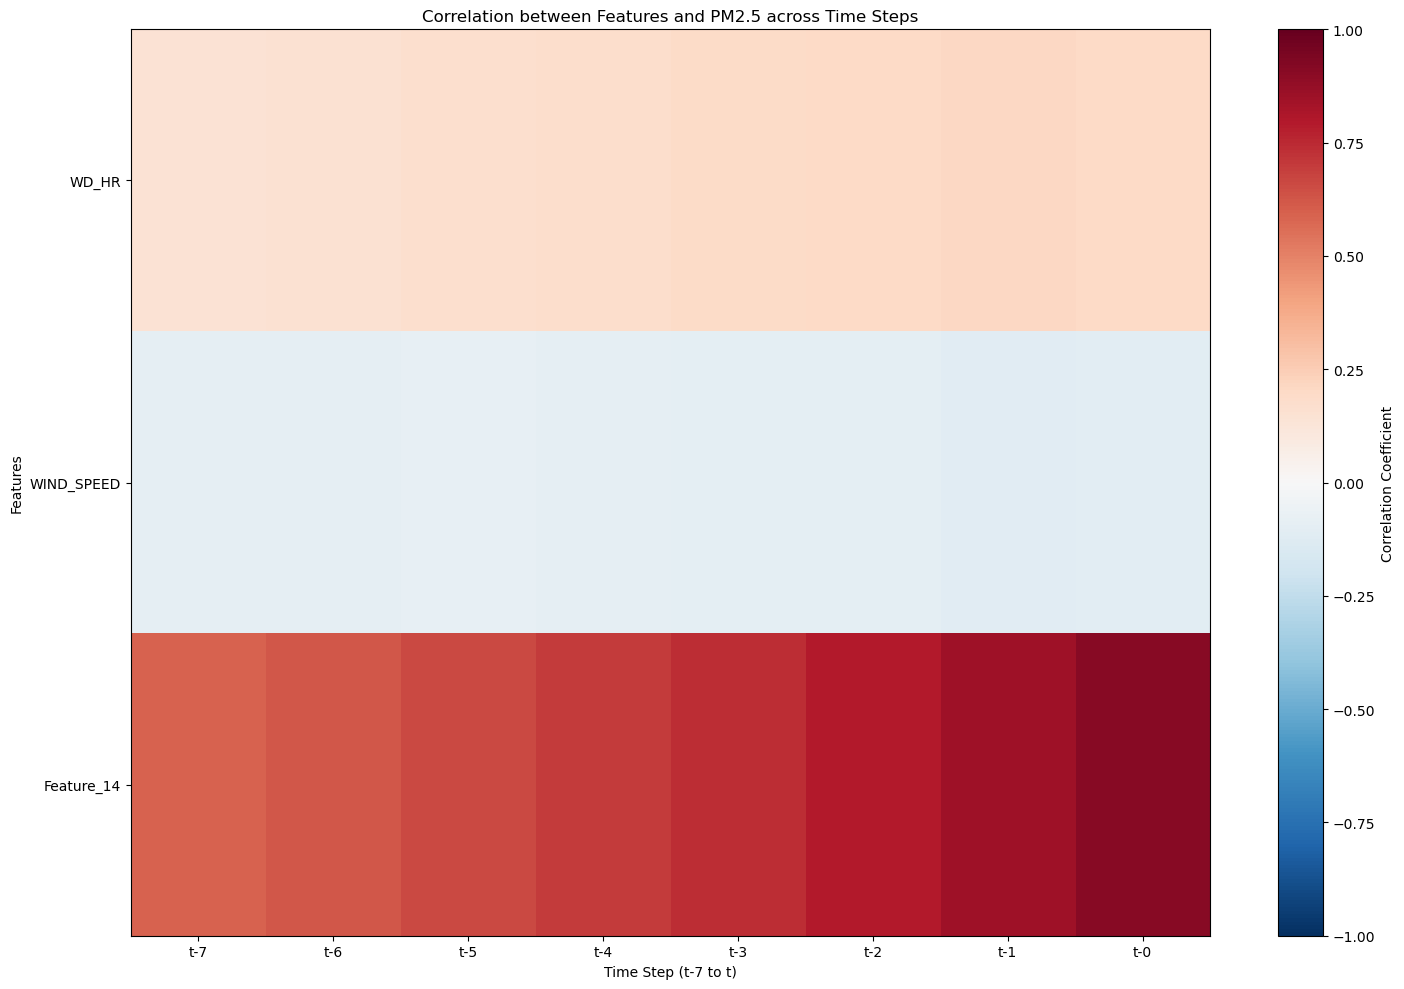


Analysis Summary:
- Total samples: 5766
- Selected features: 3 features × 8 timesteps = 24 dimensions
- Target (PM2.5) range: [0.00, 80.00]
- Target (PM2.5) mean: 11.58, std: 9.00

Feature statistics:
- Strong correlation (>0.3): 1 features: ['Feature_14']
- Moderate correlation (0.1-0.3): 1 features: ['WD_HR']
- Weak correlation (≤0.1): 1 features: ['WIND_SPEED']


In [933]:
# Analyze the training data by calculating correlation between train_x and train_y
import matplotlib.pyplot as plt

# First, let's check what we're actually working with
print("Current feats selection:", feats)
print("Length of feats:", len(feats))
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y.shape)
print()

# Let's look at the actual data structure
print("First, let's see what columns are in the original data:")
print("Train CSV columns:", list(train_df.columns))
print("Number of columns:", len(train_df.columns))
print()

# Feature names corresponding to indices 0-17 (18 features total in the CSV)
feature_names = list(train_df.columns[:-1])  # All except PM2.5
print("Available feature names:", feature_names)
print()

# Calculate correlation between each feature and target
timesteps = 8
n_selected_features = len(feats)

correlations = []
feature_correlations = {}

print("Correlation analysis between features and PM2.5:")
print("=" * 70)

# Calculate correlation for each selected feature across all timesteps
for i, feat_idx in enumerate(feats):
    if feat_idx < len(feature_names):
        feature_name = feature_names[feat_idx]
    else:
        feature_name = f'Feature_{feat_idx}'
    
    # Extract all timesteps for this feature
    start_idx = i * timesteps
    end_idx = (i + 1) * timesteps
    feature_data = train_x[:, start_idx:end_idx]
    
    # Calculate correlation for each timestep
    timestep_corrs = []
    for t in range(timesteps):
        corr = np.corrcoef(feature_data[:, t], train_y)[0, 1]
        if np.isnan(corr):  # Handle constant features
            corr = 0.0
        timestep_corrs.append(corr)
    
    # Average correlation across timesteps
    avg_corr = np.mean(timestep_corrs)
    max_corr = np.max(np.abs(timestep_corrs))
    
    feature_correlations[feature_name] = {
        'avg_correlation': avg_corr,
        'max_abs_correlation': max_corr,
        'timestep_correlations': timestep_corrs,
        'feature_idx': feat_idx
    }
    
    print(f"{feature_name:15s} (idx {feat_idx:2d}): Avg={avg_corr:7.3f}, Max_abs={max_corr:7.3f}")

print("\n" + "=" * 70)
print("Top 10 features by average absolute correlation:")
sorted_features = sorted(feature_correlations.items(), 
                        key=lambda x: abs(x[1]['avg_correlation']), 
                        reverse=True)

for i, (name, stats) in enumerate(sorted_features[:10]):
    print(f"{i+1:2d}. {name:15s} (idx {stats['feature_idx']:2d}): {stats['avg_correlation']:7.3f}")

print("\nTop 10 features by maximum absolute correlation:")
sorted_by_max = sorted(feature_correlations.items(), 
                      key=lambda x: x[1]['max_abs_correlation'], 
                      reverse=True)

for i, (name, stats) in enumerate(sorted_by_max[:10]):
    print(f"{i+1:2d}. {name:15s} (idx {stats['feature_idx']:2d}): {stats['max_abs_correlation']:7.3f}")

# Create a correlation heatmap for better visualization
plt.figure(figsize=(15, 10))
corr_matrix = np.zeros((len(feats), timesteps))

for i, feat_idx in enumerate(feats):
    if feat_idx < len(feature_names):
        feature_name = feature_names[feat_idx]
    else:
        feature_name = f'Feature_{feat_idx}'
        
    start_idx = i * timesteps
    end_idx = (i + 1) * timesteps
    feature_data = train_x[:, start_idx:end_idx]
    
    for t in range(timesteps):
        corr = np.corrcoef(feature_data[:, t], train_y)[0, 1]
        if np.isnan(corr):  # Handle constant features
            corr = 0.0
        corr_matrix[i, t] = corr

# Plot heatmap
plt.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation between Features and PM2.5 across Time Steps')
plt.xlabel('Time Step (t-7 to t)')
plt.ylabel('Features')

# Set y-axis labels
y_labels = [feature_names[feat_idx] if feat_idx < len(feature_names) else f'Feature_{feat_idx}' 
           for feat_idx in feats]
plt.yticks(range(len(feats)), y_labels, rotation=0)
plt.xticks(range(timesteps), [f't-{7-i}' for i in range(timesteps)])

plt.tight_layout()
plt.show()

print(f"\nAnalysis Summary:")
print(f"- Total samples: {train_x.shape[0]}")
print(f"- Selected features: {len(feats)} features × {timesteps} timesteps = {train_x.shape[1]} dimensions")
print(f"- Target (PM2.5) range: [{train_y.min():.2f}, {train_y.max():.2f}]")
print(f"- Target (PM2.5) mean: {train_y.mean():.2f}, std: {train_y.std():.2f}")

# Additional statistics
print(f"\nFeature statistics:")
strong_features = [name for name, stats in feature_correlations.items() 
                  if abs(stats['avg_correlation']) > 0.3]
moderate_features = [name for name, stats in feature_correlations.items() 
                    if 0.1 < abs(stats['avg_correlation']) <= 0.3]
weak_features = [name for name, stats in feature_correlations.items() 
                if abs(stats['avg_correlation']) <= 0.1]

print(f"- Strong correlation (>0.3): {len(strong_features)} features: {strong_features}")
print(f"- Moderate correlation (0.1-0.3): {len(moderate_features)} features: {moderate_features}")
print(f"- Weak correlation (≤0.1): {len(weak_features)} features: {weak_features}")

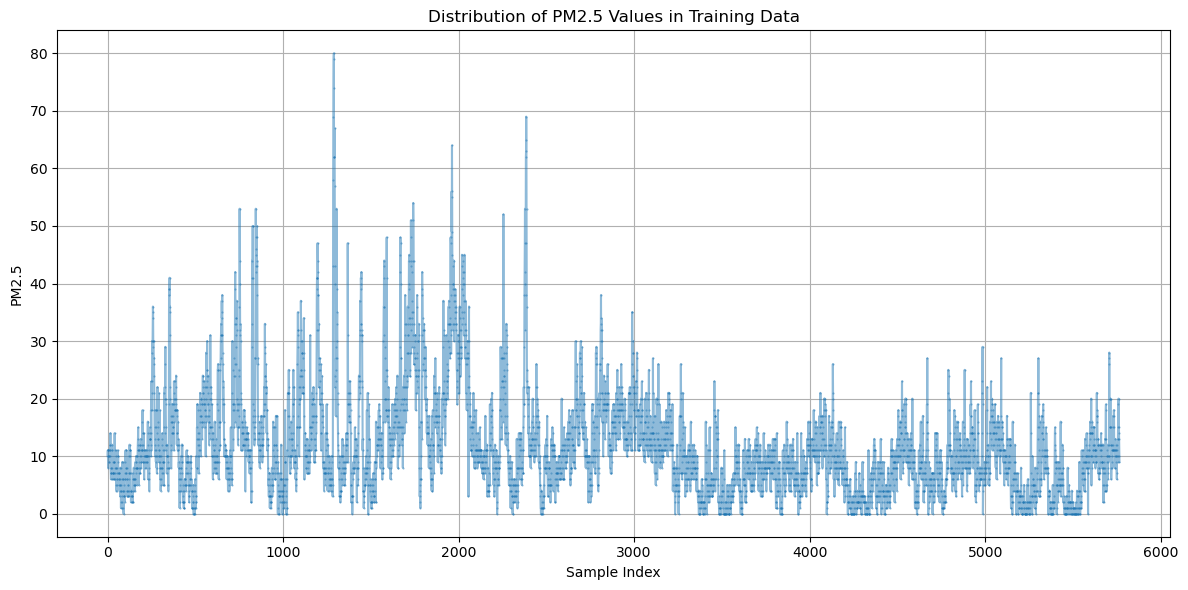

In [934]:
# Plot y vs index to visualize distribution and save in high resolution
plt.figure(figsize=(12, 6))
plt.plot(train_y, marker='.', linestyle='-', markersize=1, alpha=0.5)
plt.title('Distribution of PM2.5 Values in Training Data')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5')
plt.grid(True)
plt.tight_layout()
plt.savefig('pm25_distribution.png', dpi=300)
plt.show()

In [935]:
w, bias = minibatch(train_x, train_y, train_config)
print(w.shape, bias)
# print feature weights for analysis
# print feature
for i, feat_idx in enumerate(feats):
    if feat_idx < len(feature_names):
        feature_name = feature_names[feat_idx]
    else:
        feature_name = f'Feature_{feat_idx}'
        
    start_idx = i * 8
    end_idx = (i + 1) * 8
    feature_weights = w[start_idx:end_idx].flatten()
    avg_weight = np.mean(feature_weights)
    print(f"{feature_name:15s} (idx {feat_idx:2d}): Avg Weight={avg_weight:.4f}")

Epoch 1/500, RMSE: 5.4007
Epoch 2/500, RMSE: 5.2110
Epoch 3/500, RMSE: 5.1042
Epoch 4/500, RMSE: 5.0057
Epoch 5/500, RMSE: 4.9132
Epoch 6/500, RMSE: 4.8267
Epoch 7/500, RMSE: 4.7459
Epoch 8/500, RMSE: 4.6708
Epoch 9/500, RMSE: 4.6010
Epoch 10/500, RMSE: 4.5363
Epoch 11/500, RMSE: 4.4766
Epoch 12/500, RMSE: 4.4214
Epoch 13/500, RMSE: 4.3706
Epoch 14/500, RMSE: 4.3239
Epoch 15/500, RMSE: 4.2809
Epoch 16/500, RMSE: 4.2414
Epoch 17/500, RMSE: 4.2052
Epoch 18/500, RMSE: 4.1719
Epoch 19/500, RMSE: 4.1413
Epoch 20/500, RMSE: 4.1132
Epoch 21/500, RMSE: 4.0873
Epoch 22/500, RMSE: 4.0634
Epoch 23/500, RMSE: 4.0414
Epoch 24/500, RMSE: 4.0211
Epoch 25/500, RMSE: 4.0023
Epoch 26/500, RMSE: 3.9848
Epoch 27/500, RMSE: 3.9686
Epoch 28/500, RMSE: 3.9535
Epoch 29/500, RMSE: 3.9395
Epoch 30/500, RMSE: 3.9264
Epoch 31/500, RMSE: 3.9141
Epoch 32/500, RMSE: 3.9026
Epoch 33/500, RMSE: 3.8918
Epoch 34/500, RMSE: 3.8816
Epoch 35/500, RMSE: 3.8720
Epoch 36/500, RMSE: 3.8630
Epoch 37/500, RMSE: 3.8545
Epoch 38/5

In [936]:
# # Plot feature to PM2.5 scatter plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.scatter(train_df["NO"], train_df["PM2.5"], alpha=0.5)
# plt.title('Feature vs PM2.5 Scatter Plot')
# plt.xlabel('Feature Value')
# plt.ylabel('PM2.5 Value')
# plt.show()

In [937]:
# # Plot each feature to PM2.5 scatter plot and save the figures
# for feature in train_df.columns:
#     if feature != 'PM2.5':
#         plt.figure(figsize=(10, 6))
#         plt.scatter(train_df[feature], train_df["PM2.5"], alpha=0.5)
#         plt.title(f'{feature} vs PM2.5 Scatter Plot')
#         plt.xlabel(f'{feature} Value')
#         plt.ylabel('PM2.5 Value')
#         plt.savefig(f'{feature}_vs_PM2.5_scatter.png')
#         plt.close()

# **Testing:**


In [938]:
def parse2test(data, feats):
  x = []
  for i in range(90):
    x_tmp = data[feats,8*i: 8*i+8]
    x.append(x_tmp.reshape(-1,))

  # x.shape: (n, 15, 8)
  x = np.array(x)
  return x

In [939]:
def normalize_test_data(df, norm_params):
    data_norm = df.copy()

    for col, params in norm_params.items():
        if col in df.columns:
            data_norm[col] = (df[col] - params['mean']) / params['std']

    return data_norm

In [940]:
test_df = pd.read_csv('test.csv')
test_df

,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,WS_HR,RAINFALL,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,PM2.5
0,27.5,0.22,0.7,9.0,9.8,13.2,31.0,1.2,0.0,79.0,1.7,180.0,171.0,1.2,20.0
1,27.2,0.17,0.4,5.0,5.4,15.7,20.0,1.5,0.0,79.0,1.6,192.0,187.0,1.9,8.0
2,26.8,0.17,0.4,4.3,4.8,12.8,16.0,1.6,0.0,81.0,1.3,181.0,180.0,1.8,9.0
3,26.7,0.19,0.4,4.1,4.5,12.0,21.0,1.7,0.0,80.0,1.5,179.0,188.0,2.3,6.0
4,26.4,0.22,0.4,4.1,4.6,10.1,23.0,2.2,0.0,81.0,1.5,184.0,186.0,1.9,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,16.0,0.26,0.3,3.9,4.2,47.1,34.0,2.7,0.0,70.0,0.5,130.0,133.0,2.8,13.0
716,15.6,0.25,0.4,3.3,3.7,44.1,27.0,3.0,0.0,74.0,0.6,136.0,131.0,3.2,15.0
717,15.7,0.24,0.4,3.7,4.1,44.1,29.0,2.9,0.0,73.0,0.6,133.0,129.0,2.7,12.0
718,15.1,0.24,0.6,10.5,11.1,29.9,9.0,0.8,0.0,95.0,0.6,24.0,21.0,1.1,8.0


In [941]:
# Testing data preprocessing
def test_processing(test_df, norm=False, norm_params=norm_params):
    if norm:
        if norm_params is None:
            raise ValueError("norm_params required when norm=True")

        # Apply training normalization parameters to testing data
        data_norm = normalize_test_data(test_df, norm_params)
        data_values = data_norm.values
    else:
        # Use raw testing data
        data_values = test_df.values

    # Common processing steps
    test_data = np.transpose(np.array(np.float64(data_values)))
    test_x = parse2test(test_data, feats)

    return test_x

test_x = test_processing(test_df, norm=use_norm, norm_params=norm_params)

# **Write result as .csv**

---



In [942]:
with open('my_sol.csv', 'w', newline='') as csvf:
  writer = csv.writer(csvf)
  writer.writerow(['Id','Predicted'])

  print(test_x.shape)
  for i in range(int(test_x.shape[0])):
    # Prediction of linear regression
    prediction = (np.dot(np.reshape(w,-1),test_x[i]) + bias)[0]
    writer.writerow([i, prediction])

(90, 24)
